# Best practice in large-scale cross-dataset label transfer using CellTypist
This notebook demonstrates how to perform cell type label transfer between large scRNA-seq datasets using CellTypist.

## About model training and cell type prediction
Cell type prediction using existing models (e.g. the CellTypist built-in models) is usually fast. In other cases, a bespoke model needs to be trained based on the reference dataset of interest. This notebook deals with the latter, with a particular focus on large datasets. Make sure you have at least 30~40GB RAM before running this notebook.

## Install CellTypist

In [1]:
!pip install celltypist

  Using cached celltypist-0.2.1-py3-none-any.whl (5.3 MB)


In [2]:
import scanpy as sc
import celltypist
import time
import numpy as np

## Download two datasets for label transfer

Both datasets used in this notebook can be easily downloaded from the human [gut cell atlas](https://www.gutcellatlas.org/).

Download the dataset of 428k intestinal cells from fetal, pediatric, adult donors, and up to 11 intestinal regions ([Elmentaite et al. 2021](https://doi.org/10.1038/s41586-021-03852-1)).

In [3]:
adata_Elmentaite = sc.read('celltypist_demo_folder/gut_cell_atlas_Elmentaite.h5ad', backup_url = 'https://cellgeni.cog.sanger.ac.uk/gutcellatlas/Full_obj_raw_counts_nosoupx.h5ad')

  0%|          | 0.00/5.72G [00:00<?, ?B/s]

Since this object stores raw count expression matrix, we first log-normalise it with the library size of 10,000.

In [4]:
sc.pp.normalize_total(adata_Elmentaite, target_sum = 1e4)
sc.pp.log1p(adata_Elmentaite)

Download the other dataset of 42k immune cells from the MLNs and lamina propria of the cecum, transverse colon and sigmoid colon ([James et al. 2020](https://doi.org/10.1038/s41590-020-0602-z)).

In [5]:
adata_James = sc.read('celltypist_demo_folder/gut_cell_atlas_James.h5ad', backup_url = 'https://cellgeni.cog.sanger.ac.uk/gutcellatlas/Colon_cell_atlas.h5ad')

  0%|          | 0.00/503M [00:00<?, ?B/s]

This object is already log-normalised to 10,000 counts, so no processing is needed here.

Cell type annotation information is stashed in `Integrated_05` and `cell_type`, respectively.

In [6]:
# 134 cell types in the first data.
adata_Elmentaite.obs.Integrated_05.unique()

['DZ GC cell', 'Cycling B cell', 'gdT', 'Memory B', 'Treg', ..., 'EC cells (NPW+)', 'β cells (INS+)', 'Branch A2 (IPAN/IN)', 'Branch A3 (IPAN/IN)', 'Germ']
Length: 134
Categories (134, object): ['DZ GC cell', 'Cycling B cell', 'gdT', 'Memory B', ..., 'β cells (INS+)', 'Branch A2 (IPAN/IN)', 'Branch A3 (IPAN/IN)', 'Germ']

In [7]:
# 25 cell types in the second data.
adata_James.obs.cell_type.unique()

['B cell IgA Plasma', 'B cell memory', 'CD8 T', 'gd T', 'Mast', ..., 'Activated CD4 T', 'pDC', 'Tfh', 'Lymphoid DC', 'cycling DCs']
Length: 25
Categories (25, object): ['B cell IgA Plasma', 'B cell memory', 'CD8 T', 'gd T', ..., 'pDC', 'Tfh', 'Lymphoid DC', 'cycling DCs']

## Transfer cell type labels from the first dataset to the second dataset
This section shows how to transfer cell type labels from `adata_Elmentaite` to `adata_James`, and to assess and visualise the prediction result.

### (Optional) Downsample cells for the first dataset
First we downsample the 428k cells in `adata_Elmentaite`.

In [8]:
adata_Elmentaite.shape

(428469, 33538)

There are several ways to downsample cells, including: 1) downsampling cells to a given number; 2) downsampling cells to a given number, with cell types fairly represented (i.e. rare cell types are sampled with a higher probability); 3) downsampling cells from each cell type to a given number; 4) other downsampling strategies. For this dataset, we used the third approach with the aid of [celltypist.samples.downsample_adata](https://celltypist.readthedocs.io/en/latest/celltypist.html#celltypist.samples.downsample_adata). You can also try the first or second options using this function, or any other custom downsampling strategies suited to your data.

Downsampling will be beneficial when cells are well annotated, say, cells from a given cell type are transcriptionally homogeneous. *Skip the whole sub-section if you think the available cell type information is coarse and downsampling may skew the cell type representations in the original dataset.*

In [9]:
# Sample 500 cells from each cell type for `adata_Elmentaite`.
# All cells from a given cell type will be selected if the cell type size is < 500.
sampled_cell_index = celltypist.samples.downsample_adata(adata_Elmentaite, mode = 'each', n_cells = 500, by = 'Integrated_05', return_index = True)

By default, only sampled cell indices are returned, which can keep the original `adata_Elmentaite` intact. Note these sampled cells are only used for model training.

In [10]:
print(f"Number of downsampled cells for training: {len(sampled_cell_index)}")

Number of downsampled cells for training: 54853


### (Suggested) Feature selection for the first dataset

A feature selection step will restrict the number of genes during training, and can improve both training efficiency and prediction accuracy. It is recommended in most cases (though CellTypist models are proved to be robust when all genes are used).  
  
One example of feature selection is using the [scanpy.pp.highly_variable_genes](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html). Depending on the datasets, you may need to take into account batch effects (e.g. by specifying `batch_key`), add/remove a specific list of genes (e.g. VDJ genes for immune cells), combine high-confidence features across zoomed-in compartments, or any other approaches tailored to your data.

In this notebook, we performed feature selection using CellTypist. This may not be the best approach for your data as noted above, but performs well as tested in several datasets.

First, use [celltypist.train](https://celltypist.readthedocs.io/en/latest/celltypist.html#celltypist.train.train) to train a quick CellTypist model by stochastic gradient descent learning on 10 cpus, with only a limited number of iterations (5).

In [11]:
# Use `celltypist.train` to quickly train a rough CellTypist model.
# You can also set `mini_batch = True` to enable mini-batch training.
t_start = time.time()
model_fs = celltypist.train(adata_Elmentaite[sampled_cell_index], 'Integrated_05', n_jobs = 10, max_iter = 5, use_SGD = True)
t_end = time.time()
print(f"Time elapsed: {t_end - t_start} seconds")

🍳 Preparing data before training
✂️ 4047 non-expressed genes are filtered out
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
✅ Model training done!


Time elapsed: 299.6024606227875 seconds


It takes 5 minutes to train this dataset with 33k genes and 134 cell types from 55k cells. Note you can increase `max_iter` to get a more accurate model at the expense of increased runtime.

This model is trained from all genes with only five epochs, and thus is not accurate enough for cell type prediction. But the information about genes can be utilised. Here, we drew top 100 important genes from each cell type as ranked by their absolute regression coefficients associated with the given cell type. For datasets with only several cell types, you may want to increase the top gene number from 100 to for example 300 in order to get a sufficient number of genes for final use.

In [12]:
gene_index = np.argpartition(np.abs(model_fs.classifier.coef_), -100, axis = 1)[:, -100:]

We next combine/union these genes across cell types.

In [13]:
gene_index = np.unique(gene_index)

These genes will be used for downstream model training.

In [14]:
print(f"Number of genes selected: {len(gene_index)}")

Number of genes selected: 5103


### Model training and label transfer

With the downsampled cells (55k) and selected features (5k), we next train `adata_Elmentaite` using [celltypist.train](https://celltypist.readthedocs.io/en/latest/celltypist.html#celltypist.train.train).

To allow for unbiased probability estimates, here we used the non-SGD version of CellTypist training (i.e. a traditional logistic regression framework).

In [15]:
# Add `check_expression = False` to bypass expression check with only a subset of genes.
t_start = time.time()
model = celltypist.train(adata_Elmentaite[sampled_cell_index, gene_index], 'Integrated_05', check_expression = False, n_jobs = 10, max_iter = 100)
t_end = time.time()
print(f"Time elapsed: {(t_end - t_start)/60} minutes")

🍳 Preparing data before training
✂️ 596 non-expressed genes are filtered out
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!


Time elapsed: 42.38707377115885 minutes


It takes 42 minutes to train this dataset with 5k genes and 134 cell types from 55k cells. Note you can increase `max_iter` to possibly get a more accurate model at the expense of increased runtime.

First, save this model locally for future use.

In [16]:
# Save the model.
model.write('celltypist_demo_folder/model_from_Elmentaite_2021.pkl')

Next, use [celltypist.annotate](https://celltypist.readthedocs.io/en/latest/celltypist.html#celltypist.annotate.annotate) to predict `adata_James` using this model.

In [17]:
# CellTypist prediction without over-clustering and majority-voting.
t_start = time.time()
predictions = celltypist.annotate(adata_James, model = 'celltypist_demo_folder/model_from_Elmentaite_2021.pkl')
t_end = time.time()
print(f"Time elapsed: {t_end - t_start} seconds")

🔬 Input data has 41650 cells and 18927 genes
🔗 Matching reference genes in the model
🧬 2866 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


Time elapsed: 6.5466063022613525 seconds


It takes 6 seconds to predict a dataset of 42k cells and 19k genes.

By default (`majority_voting = False`), CellTypist will infer the identity of each query cell independently. This leads to raw predicted cell type labels, and usually finishes within seconds. You can also turn on the majority-voting classifier (`majority_voting = True`), which refines cell identities within local subclusters after an over-clustering approach at the cost of increased runtime.

In [18]:
# CellTypist prediction with over-clustering and majority-voting.
t_start = time.time()
predictions = celltypist.annotate(adata_James, model = 'celltypist_demo_folder/model_from_Elmentaite_2021.pkl', majority_voting = True)
t_end = time.time()
print(f"Time elapsed: {t_end - t_start} seconds")

🔬 Input data has 41650 cells and 18927 genes
🔗 Matching reference genes in the model
🧬 2866 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


Time elapsed: 22.271843671798706 seconds


It takes 22 seconds to both predict and majority-vote a dataset of 42k cells and 19k genes.

The results include both predicted cell type labels (`predicted_labels`), over-clustering result (`over_clustering`), and predicted labels after majority voting in local subclusters (`majority_voting`). Note in the `predicted_labels`, each query cell gets its inferred label by choosing the most probable cell type among all possible cell types in the given model.

In [19]:
predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
index,,,
AAACGGGAGGTGCAAC-1-Pan_T7935487,IgA plasma cell,154,IgA plasma cell
AAAGATGTCCTCAACC-1-Pan_T7935487,IgA plasma cell,23,IgA plasma cell
AAAGTAGTCTTACCGC-1-Pan_T7935487,IgA plasma cell,154,IgA plasma cell
AACCATGCAGATTGCT-1-Pan_T7935487,IgG plasma cell,154,IgA plasma cell
AACCATGTCCTGCCAT-1-Pan_T7935487,IgG plasma cell,79,IgA plasma cell
...,...,...,...
TTTGTCACAAGTTAAG-1-Human_colon_16S8000484,Memory B,2,Memory B
TTTGTCAGTACCGAGA-1-Human_colon_16S8000484,CD8 Tmem,12,CD8 Tmem
TTTGTCATCAACACCA-1-Human_colon_16S8000484,Activated CD4 T,205,SELL+ CD4 T


Visualise the correspondence between this prediction result and the ground-truth cell types (`cell_type` in `adata_James.obs`) using [celltypist.dotplot](https://celltypist.readthedocs.io/en/latest/celltypist.html#celltypist.plot.dotplot).

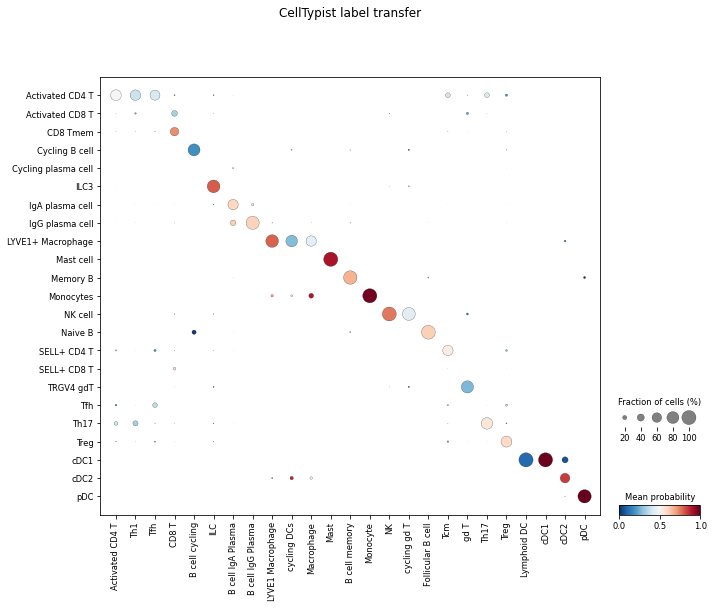

In [20]:
# You can also change the value of `use_as_prediction` to `predicted_labels` to compare the raw prediction result with the pre-defined cell types.
celltypist.dotplot(predictions, use_as_reference = 'cell_type', use_as_prediction = 'majority_voting')

For each cell type in `adata_James` (column), this plot shows how it can be 'decomposed' into different cell types predicted by the CellTypist model from `adata_Elmentaite` (rows).

Transform the prediction result into an `AnnData`.

In [21]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata = predictions.to_adata()

Compared to `adata_James`, the new `adata` has additional prediction information in `adata.obs` (`predicted_labels`, `over_clustering`, `majority_voting` and `conf_score`). Of note, all these columns can be prefixed with a specific string by setting `prefix` in [to_adata](https://celltypist.readthedocs.io/en/latest/celltypist.html#celltypist.classifier.AnnotationResult.to_adata).

In [22]:
adata.obs.iloc[:, -4:]

,predicted_labels,over_clustering,majority_voting,conf_score
index,,,,
AAACGGGAGGTGCAAC-1-Pan_T7935487,IgA plasma cell,154,IgA plasma cell,0.879683
AAAGATGTCCTCAACC-1-Pan_T7935487,IgA plasma cell,23,IgA plasma cell,0.995480
AAAGTAGTCTTACCGC-1-Pan_T7935487,IgA plasma cell,154,IgA plasma cell,0.974575
AACCATGCAGATTGCT-1-Pan_T7935487,IgG plasma cell,154,IgA plasma cell,0.835985
AACCATGTCCTGCCAT-1-Pan_T7935487,IgG plasma cell,79,IgA plasma cell,0.856283
...,...,...,...,...
TTTGTCACAAGTTAAG-1-Human_colon_16S8000484,Memory B,2,Memory B,0.995788
TTTGTCAGTACCGAGA-1-Human_colon_16S8000484,CD8 Tmem,12,CD8 Tmem,0.975453
TTTGTCATCAACACCA-1-Human_colon_16S8000484,Activated CD4 T,205,SELL+ CD4 T,0.942779


Visually compare the original cell type annotations with the CellTypist predictions.

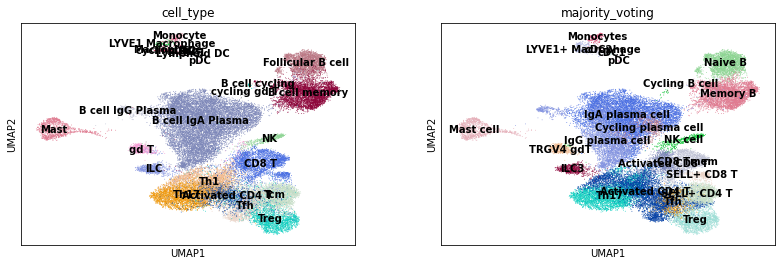

In [23]:
sc.pl.umap(adata, color = ['cell_type', 'majority_voting'], legend_loc = 'on data')

## Transfer cell type labels from the second dataset to the first dataset
This section shows how to transfer cell type labels from `adata_James` to `adata_Elmentaite`, and to assess and visualise the prediction result.

Since `adata_James` has a modest number of cells (42k), we do not perform cell downsampling for this dataset before training.  

The workflow is the same as that in the previous section.  
  
First, perform a fast feature selection.

In [24]:
# Use `celltypist.train` to quickly train a rough CellTypist model.
# You can also set `mini_batch = True` to enable mini-batch training.
t_start = time.time()
model_fs = celltypist.train(adata_James, 'cell_type', n_jobs = 10, max_iter = 5, use_SGD = True)
t_end = time.time()
print(f"Time elapsed: {t_end - t_start} seconds")

🍳 Preparing data before training
✂️ 552 non-expressed genes are filtered out
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
✅ Model training done!


Time elapsed: 65.56434988975525 seconds


Similarly, select top features across cell types.

In [25]:
# This dataset has fewer cell types (25) than `adata_Elmentaite`, use top 200 genes instead.
gene_index = np.argpartition(np.abs(model_fs.classifier.coef_), -200, axis = 1)[:, -200:]
gene_index = np.unique(gene_index)
print(f"Number of genes selected: {len(gene_index)}")

Number of genes selected: 2783


Train a CellTypist model.

In [26]:
# Add `check_expression = False` to bypass expression check with only a subset of genes.
t_start = time.time()
model = celltypist.train(adata_James[:, gene_index], 'cell_type', check_expression = False, n_jobs = 10, max_iter = 100)
t_end = time.time()
print(f"Time elapsed: {(t_end - t_start)/60} minutes")

🍳 Preparing data before training
✂️ 71 non-expressed genes are filtered out
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!


Time elapsed: 17.494721758365632 minutes


Save this model and then use it to predict `adata_Elmentaite`.

In [27]:
model.write('celltypist_demo_folder/model_from_James_2020.pkl')

In [28]:
# You can also set `majority_voting = True`, which will take much longer time as the query dataset is large now (428k cells).
t_start = time.time()
predictions = celltypist.annotate(adata_Elmentaite, model = 'celltypist_demo_folder/model_from_James_2020.pkl')
t_end = time.time()
print(f"Time elapsed: {t_end - t_start} seconds")

🔬 Input data has 428469 cells and 33538 genes
🔗 Matching reference genes in the model
🧬 2712 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


Time elapsed: 23.990260124206543 seconds


Visualise the result using [celltypist.dotplot](https://celltypist.readthedocs.io/en/latest/celltypist.html#celltypist.plot.dotplot).

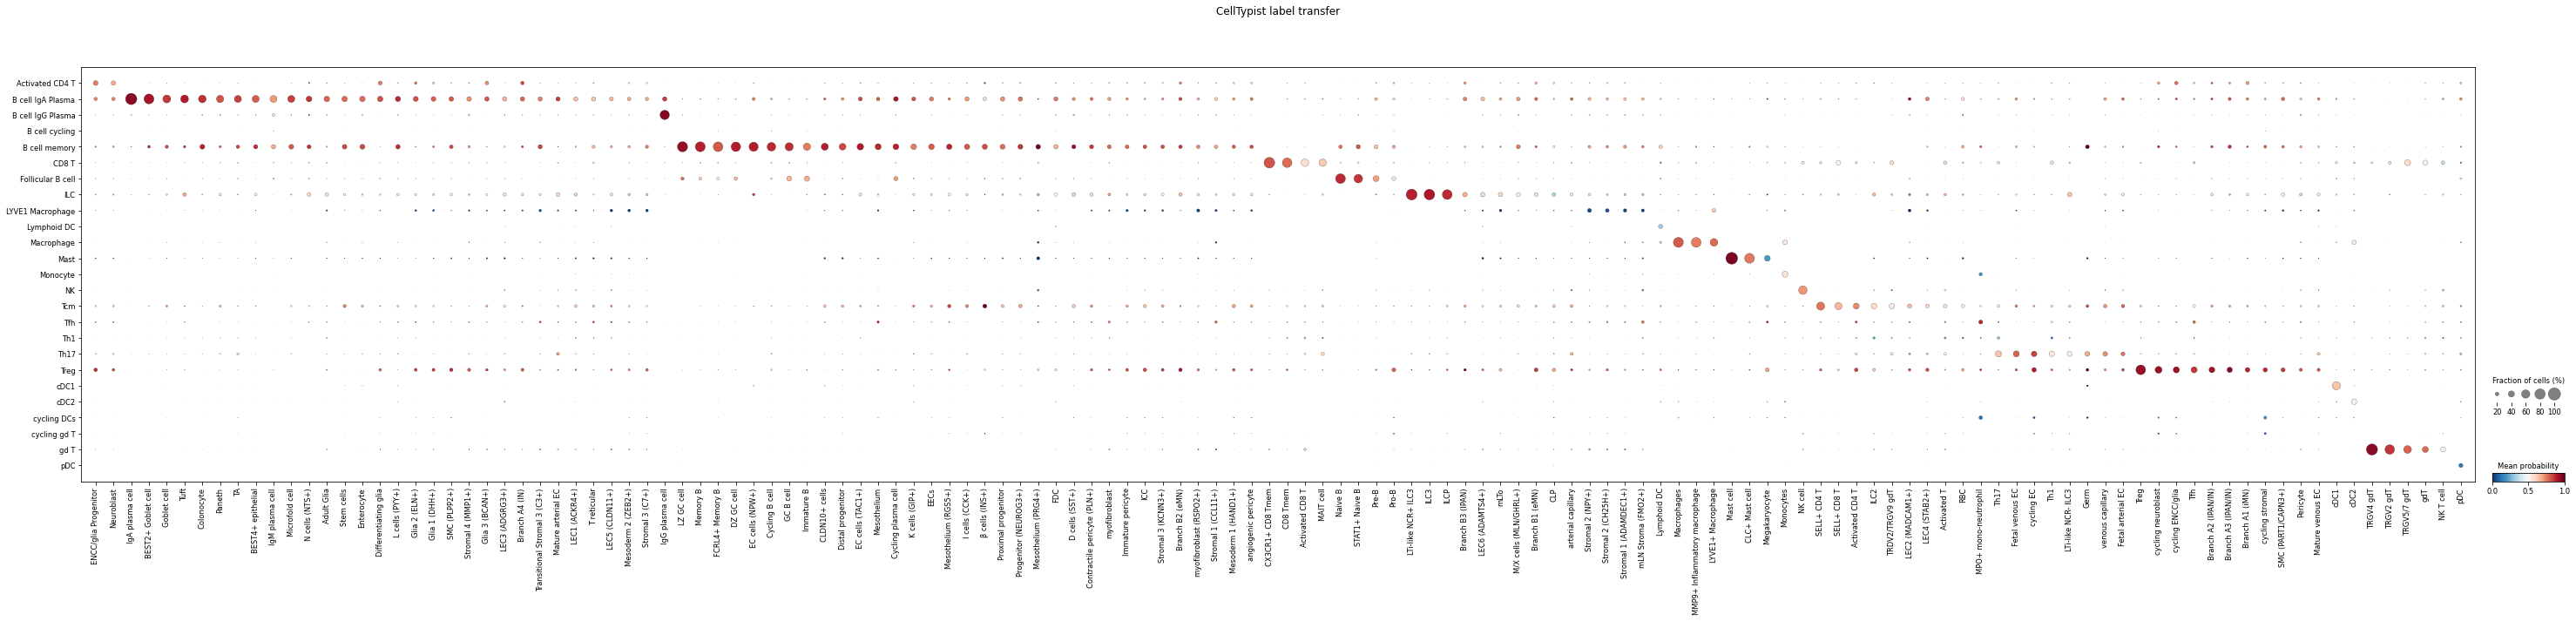

In [29]:
celltypist.dotplot(predictions, use_as_reference = 'Integrated_05', use_as_prediction = 'predicted_labels')

As the image shows, many non-immune cells in `adata_Elmentaite` are predicted with low probabilities as expected, as `adata_James` contains only immune cells.

## Feature selection & model training in one command

Overall, we suggest the users to perform their own feature selection before training to alleviate the training burden.  
  
However, if you want to perform feature selection and model training all based on CellTypist as in the previous sections, the training function `celltypist.train` has the arguments `feature_selection = True` (default to `False`) and `top_genes = 300` (default to `300`) to perform the feature selection and model training within one run.

As noted earlier, increasing `max_iter` (default to `1000`) during both feature selection and data training can result in longer runtime but possibly an improved model.

In [30]:
# Not run. One command to select features and train the model.
#model = celltypist.train(adata_James, 'cell_type', n_jobs = 10, max_iter = 100, feature_selection = True, top_genes = 300)

More information can be found [here](https://github.com/Teichlab/celltypist#supplemental-guidance-generate-a-custom-model).